<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/micro_fluctuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time

from astropy.io import fits
from scipy.signal import convolve

from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


# А) Карта из GERLUMPH

Вытащим параметры карты из файла mapmeta.dat:

In [ ]:
avmag = 13.0884
avnumrays_perpix = 411.083

res = 10000
length = 25

kappa = 0.72
gamma = 0.1
kappa_c = 0.300

mean_magn = 1./((1.-kappa)**2 - gamma**2)
mean_magn

14.619883040935669

Откроем карту и перемасштабируем её:

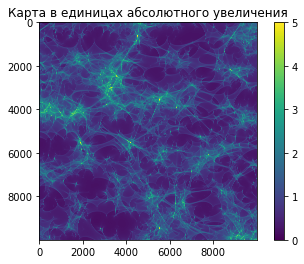

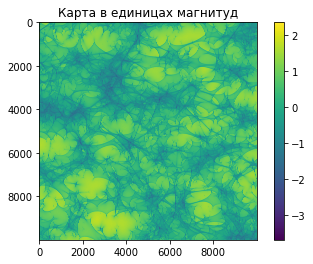

(2.0, -3.0)

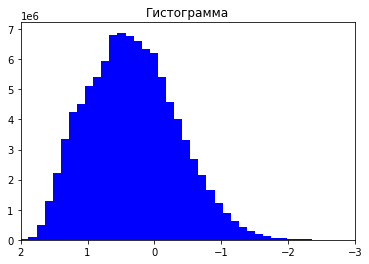

In [ ]:
filename = ("Gerlumph/map.bin")
mapp = open(filename,"rb")
image = np.fromfile(mapp,'i',-1,"")

image = image * avmag / avnumrays_perpix / mean_magn

image = image.reshape(int(res), int(res))

#plt.figure(figsize = (20,20))

plt.imshow(image, vmin=0, vmax = 5)
plt.title('Карта в единицах абсолютного увеличения')
plt.colorbar()
plt.show()

image_mod = -2.5*np.log10(image)

plt.imshow(image_mod)
plt.title('Карта в единицах магнитуд')
plt.colorbar()
plt.show()

plt.hist(image_mod.flatten(), bins=50,color='blue')
plt.title('Гистограмма')
plt.xlim(2,-3)

# Б) Обычная (1000х1000) карта микролинзирования

Карта:

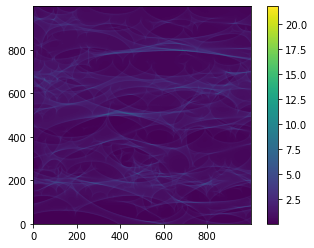

IRIS314: pixmax0 = 5.0 pixminx = -0.0 pixminy = -0.0 pixdif = 10.0 fracpixd = 0.1


In [ ]:
image_data = fits.getdata("notebooks/IRIS314.fits")
image = 10**(.4*(image_data-1024.0)/256.0)
             
plt.imshow(image, origin='lower')
plt.colorbar()
plt.show()

hdul = fits.open("notebooks/IRIS314.fits")  # open a FITS file
hdr = hdul[0].header  # the primary HDU header
print('IRIS314:','pixmax0 =',hdr['pixmax0'], 'pixminx =', hdr['x-pos'], 'pixminy =', hdr['y-pos'], 'pixdif =', hdr['length'], 'fracpixd =', hdr['fracpixd'])

# В) Карта-ступенька

Сформируем карту-"ступеньку".

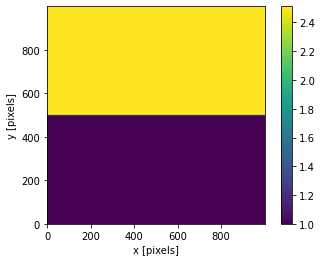

In [ ]:
side = 1000

stupenka_data = np.zeros((side, side))

for i in range(0, side):
    for j in range(0, side):
        if i<int(side/2):
            stupenka_data[i][j]=1024
        else:
            stupenka_data[i][j]=1280

stupenka = 10**(.4*(stupenka_data-1024)/256.)
            
plt.imshow(stupenka, origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

# Создаём фильтр-кружок (маску)

Теперь запишем функцию, которая генерирует наш фильтр-кружок (маску). Входные параметры:

**rad_pix** - радиус фильтра в пикселях (целое число).

**rads, ld** - таблично заданное распределение яркости вдоль радиуса фильтра-кружка.


In [ ]:
def createMyMask(rad_pix, rads, ld):
    
    w = 2*rad_pix
    h = 2*rad_pix
    
    center = [rad_pix, rad_pix]
    
    dist_from_center = np.zeros((w, h))
    z = dist_from_center*0    
    
    new_grid = rads/np.max(rads) #перенормируем заданное распределение на радиус фильтра (на всякий случай)
    new_grid = new_grid * rad_pix
    
    delta=1 
    x = np.arange(0, w, delta)
    y = np.arange(0, h, delta)

    Y, X = np.meshgrid(x,y)

    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    for i in range(0, w):
        for j in range(0, h):
            if dist_from_center[i][j] < rad_pix:
                z[i][j] = np.interp(np.around(dist_from_center[i][j]), new_grid, ld)
            else:
                z[i][j] = 0
    
    return z#/np.sum(z)

Проверим её на плоском и на гауссовом источниках:

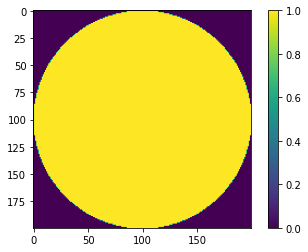

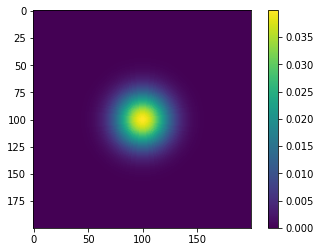

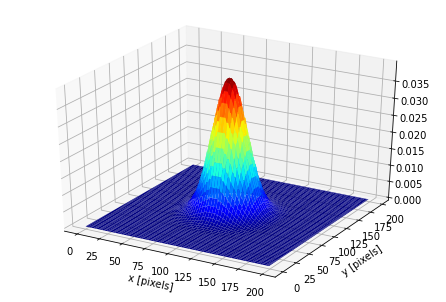

In [ ]:
try_radius = 100
try_rads = np.arange(0, 60, 1)

try_ld_flat = np.ones(len(try_rads))
try_mask_flat = createMyMask(try_radius, try_rads, try_ld_flat)

plt.imshow(try_mask_flat)
plt.colorbar()
plt.show()

try_sigma = 10
try_ld_gauss = (1/np.sqrt(2*np.pi)/try_sigma)*np.exp(-try_rads**2/2/try_sigma**2)

try_mask_gauss = createMyMask(try_radius, try_rads, try_ld_gauss)

plt.imshow(try_mask_gauss)
plt.colorbar()
plt.show()

#гауссовый источник дополнительно нарисуем в 3D

import pylab
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

x = np.arange(0,2*try_radius, 1)
y = np.arange(0,2*try_radius, 1)

X,Y = np.meshgrid(x, y)

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(X,Y, try_mask_gauss, rstride=3, cstride=3, cmap=cm.jet)
pylab.xlabel('x [pixels]')
pylab.ylabel('y [pixels]')

pylab.show()

# Вырезаем кружок из карты

Определим функцию, которая вырезает кружок из нужной нам карты:

In [ ]:
from matplotlib.patches import Rectangle

def cut_circle(image, center, rad_pix, graphics):
    
    kusok = np.zeros((2*rad_pix, 2*rad_pix))
    
    for i in range(center[1]-rad_pix, center[1]+rad_pix):
        for j in range(center[0]-rad_pix, center[0]+rad_pix):
             kusok[i - (center[1]-rad_pix)][j - (center[0]-rad_pix)] = image[i][j]
    
    circle_ones = createMyMask(rad_pix, np.arange(0, rad_pix, 1), np.ones(rad_pix))
    mult = np.multiply(circle_ones, kusok)
    
    if graphics:
        
        plt.imshow(image, origin='lower')
        plt.colorbar()
        plt.gca().add_patch( Rectangle( (center[0]-rad_pix, center[1]-rad_pix), 2*rad_pix, 2*rad_pix, fill=None))
        plt.show()

        plt.imshow(kusok, origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(mult, origin='lower')
        plt.colorbar()
        plt.show()
    
    return mult

Приготовления закончены. Теперь вырежем из карты кружок радиусом в 15 пикселей (максимальный радиус сверхновой на карте из герлампф).

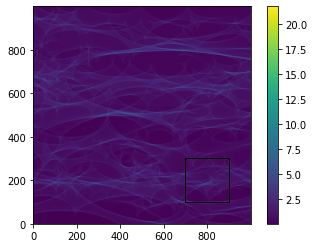

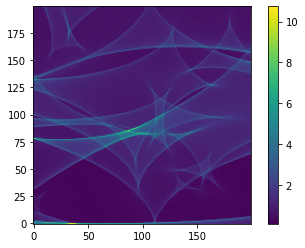

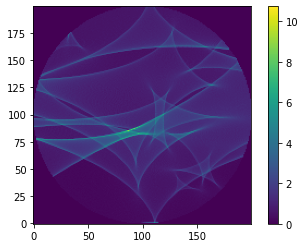

In [ ]:
cut = cut_circle(image, (800,200), 100, graphics=True)

#plt.imshow(cut)
#plt.colorbar()
#plt.show()

# Считаем флуктуации от микролинзирования

Функция, которая считает флуктуации от микролинзирования. Входные параметры:

**mapp** - карта микролинзирования,

**cntr** - точка, в которой сверхновая начинает расширение,

**max_radius** - максимальный радиус сверхновой,

**time_grid** - массив с сеткой по времени,

**rads_grid** - двумерный массив с сеткой по координатам вдоль радиуса для каждого момента времени,

**light_grid_gauss, light_grid_flat** - двумерный массив, содержащий значения яркости вдоль радиуса для гаусового источника и для точечного соответственно для каждого момента времени,

**Graphics** - выводит или не выводит промежуточные иллюстрации.

In [ ]:
def micro(mapp, cntr, max_radius, time_grid, rads_grid, light_grid_gauss, light_grid_flat, Graphics):

    t_0 = time.time()
    
    velocity = 1 #пусть у нас будет такой коэффициент линейной связи радиуса и времени
    r_0 = 2       #начальный радиус не может быть нулевым 
    
    for t in range(0, len(time_grid) ):

        radius_now = velocity * time_grid[t] + r_0

        if radius_now < max_radius:
            
            if Graphics == True:
              print('Radius is', radius_now, 'pixels now. Profile at this moment:')
              #plt.plot(rads_grid[t][1:radius_now], light_grid_flat[t][1:radius_now])
              plt.plot(rads_grid[t][1:radius_now], light_grid_gauss[t][1:radius_now])
              plt.xlim((0,100))
              plt.show()

            mask_now_gauss = createMyMask(radius_now, rads_grid[t][1:radius_now], light_grid_gauss[t][1:radius_now])
            mask_now_flat = createMyMask(radius_now, rads_grid[t][1:radius_now], light_grid_flat[t][1:radius_now])

            #if Graphics == True:
            #  plt.imshow(mask_now_gauss)
            #  plt.colorbar()
            #  plt.show()

    #        svertka_now_gauss = convolve(image, mask_now_gauss, mode='same') 
    #        svertka_now_flat = convolve(image, mask_now_flat, mode='same')

            #plt.imshow(svertka_now_gauss)
            #plt.colorbar()
            #plt.show()        

            cut_now = cut_circle(mapp, cntr, radius_now, graphics=False)

            #if Graphics == True:
            #  plt.imshow(cut_now)
            #  plt.colorbar()
            #  plt.show()

            mult_gauss = np.multiply(cut_now, mask_now_gauss)
            mult_flat = np.multiply(cut_now, mask_now_flat)

            #if Graphics == True:
            #  plt.imshow(mult_gauss)
            #  plt.colorbar()
            #  plt.show()

            dm_gauss[t] = mult_gauss.sum()/mask_now_gauss.sum()
            dm_flat[t] = mult_flat.sum()/mask_now_flat.sum()

            #clear_output()

            print(round( t/len(time_grid)*100 ), '% completed.', round( time.time() - t_0 ), 'seconds passed')

        else:
            print('Ooops, radius_now =', radius_now,'>',max_radius) #ограничим радиус сверху
            sys.exit()
            
    return dm_gauss, dm_flat

Входные данные:

In [ ]:
max_time = 95
time_grid = np.arange(0, max_time, 1)

center = (800, 200)
max_radius = 100

#cформируем рабочие массивы

rads_grid = np.zeros( (len(time_grid), max_radius) )
light_grid_gauss = np.zeros( (len(time_grid), max_radius) )
light_grid_flat = np.ones( (len(time_grid), max_radius) )/len(time_grid)

dm_gauss = np.zeros(len(time_grid))
dm_flat = np.zeros(len(time_grid))

#зададим данные (распределения яркости в различные моменты времени)

for j in range( 0, len(time_grid) ):
    for k in range( 0, max_radius ):

        rads_grid[j][k] = k 

        sigma = 10 + time_grid[j]/5 #пускай для начала зависимость будет такой
       
        light_grid_gauss[j][k] = (1/np.sqrt(2*np.pi)/sigma)*np.exp(-rads_grid[j][k]**2/2/sigma**2)
        
    #plt.plot(rads_grid[j][1:k], light_grid_gauss[j][1:k])
    #plt.plot(rads_grid[j][1:k], light_grid_flat[j][1:k])
    
#plt.grid()
#plt.xlabel('Radius [pixels]')
#plt.show()

Radius is 2 pixels now. Profile at this moment:


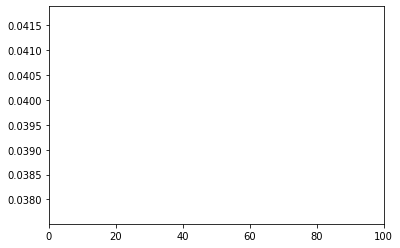

0 % completed. 0 seconds passed
Radius is 3 pixels now. Profile at this moment:


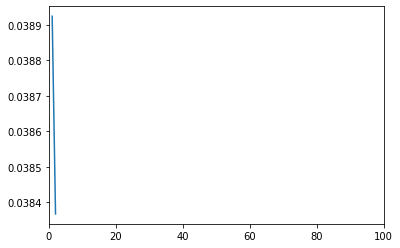

1 % completed. 0 seconds passed
Radius is 4 pixels now. Profile at this moment:


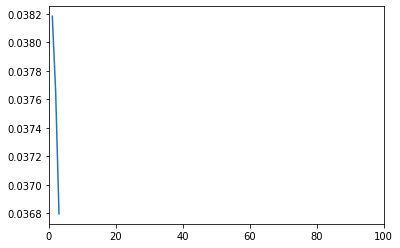

2 % completed. 1 seconds passed
Radius is 5 pixels now. Profile at this moment:


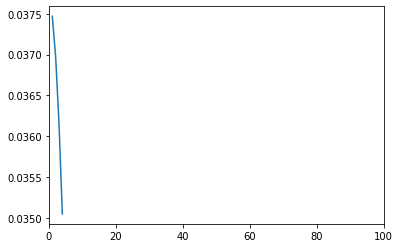

3 % completed. 1 seconds passed
Radius is 6 pixels now. Profile at this moment:


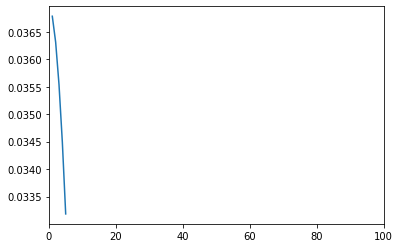

4 % completed. 1 seconds passed
Radius is 7 pixels now. Profile at this moment:


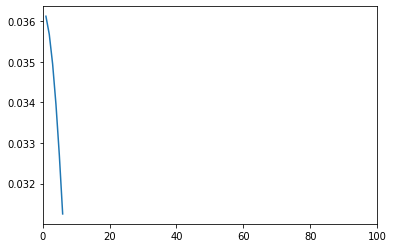

5 % completed. 1 seconds passed
Radius is 8 pixels now. Profile at this moment:


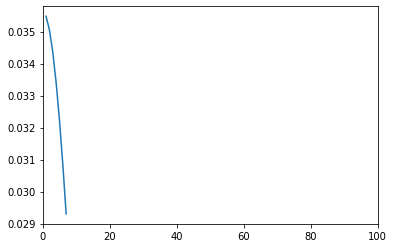

6 % completed. 1 seconds passed
Radius is 9 pixels now. Profile at this moment:


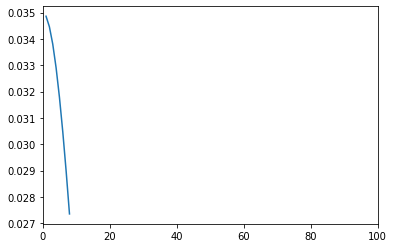

7 % completed. 2 seconds passed
Radius is 10 pixels now. Profile at this moment:


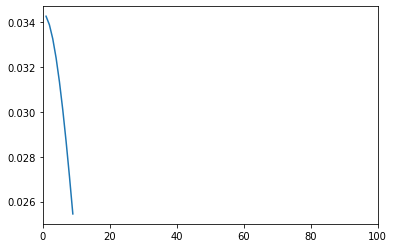

8 % completed. 2 seconds passed
Radius is 11 pixels now. Profile at this moment:


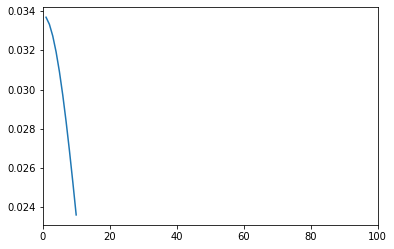

9 % completed. 2 seconds passed
Radius is 12 pixels now. Profile at this moment:


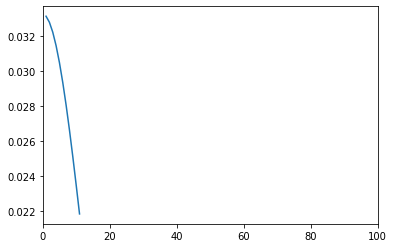

11 % completed. 2 seconds passed
Radius is 13 pixels now. Profile at this moment:


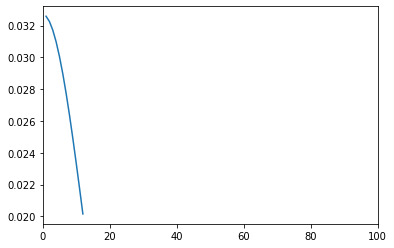

12 % completed. 2 seconds passed
Radius is 14 pixels now. Profile at this moment:


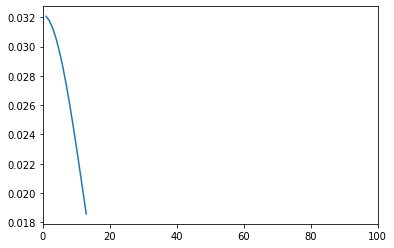

13 % completed. 3 seconds passed
Radius is 15 pixels now. Profile at this moment:


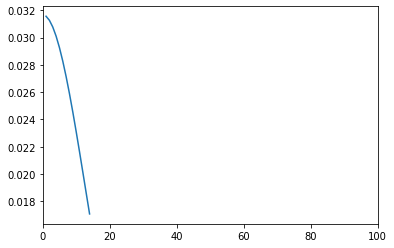

14 % completed. 3 seconds passed
Radius is 16 pixels now. Profile at this moment:


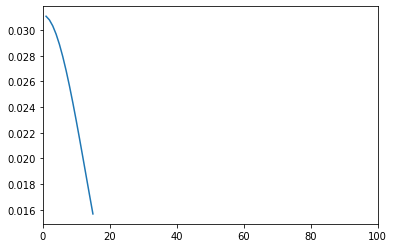

15 % completed. 3 seconds passed
Radius is 17 pixels now. Profile at this moment:


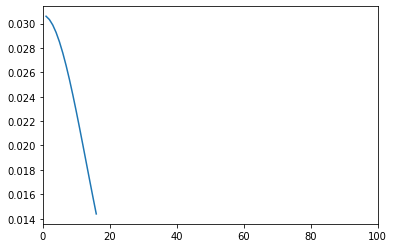

16 % completed. 3 seconds passed
Radius is 18 pixels now. Profile at this moment:


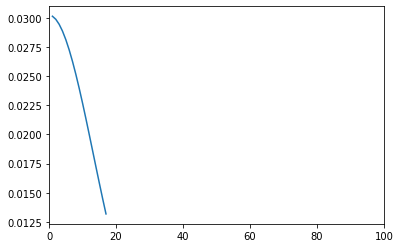

17 % completed. 3 seconds passed
Radius is 19 pixels now. Profile at this moment:


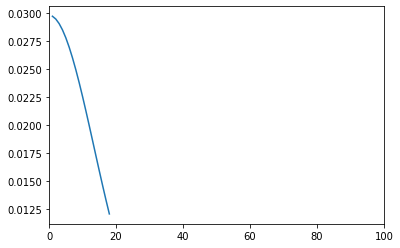

18 % completed. 3 seconds passed
Radius is 20 pixels now. Profile at this moment:


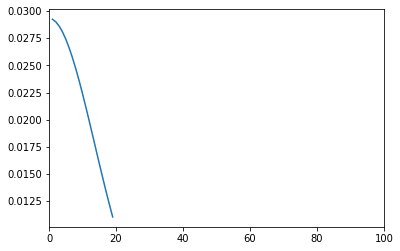

19 % completed. 4 seconds passed
Radius is 21 pixels now. Profile at this moment:


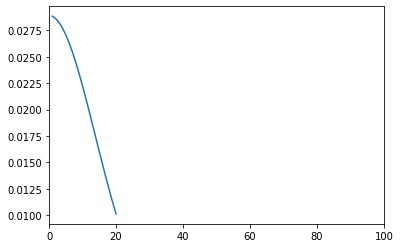

20 % completed. 4 seconds passed
Radius is 22 pixels now. Profile at this moment:


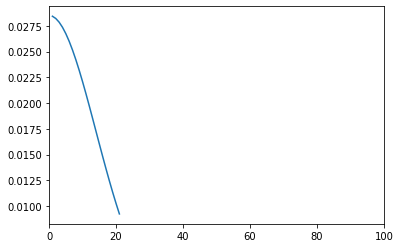

21 % completed. 4 seconds passed
Radius is 23 pixels now. Profile at this moment:


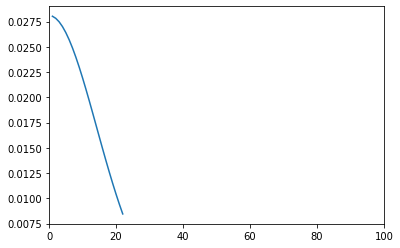

22 % completed. 5 seconds passed
Radius is 24 pixels now. Profile at this moment:


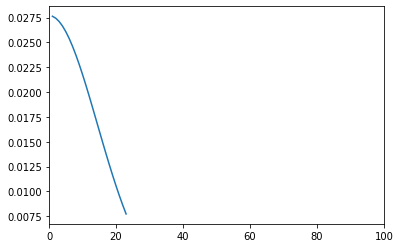

23 % completed. 5 seconds passed
Radius is 25 pixels now. Profile at this moment:


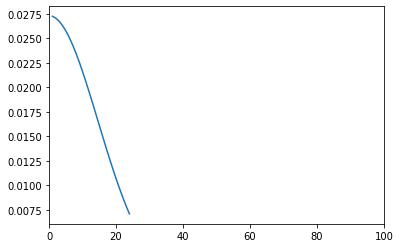

24 % completed. 5 seconds passed
Radius is 26 pixels now. Profile at this moment:


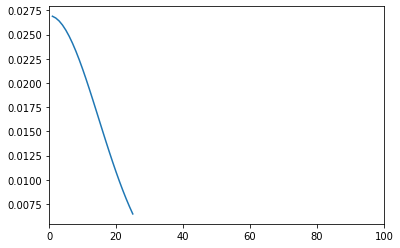

25 % completed. 5 seconds passed
Radius is 27 pixels now. Profile at this moment:


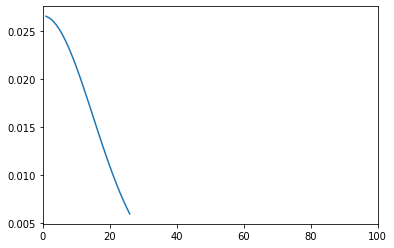

26 % completed. 5 seconds passed
Radius is 28 pixels now. Profile at this moment:


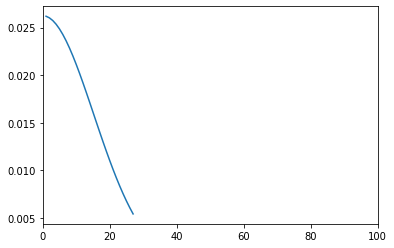

27 % completed. 6 seconds passed
Radius is 29 pixels now. Profile at this moment:


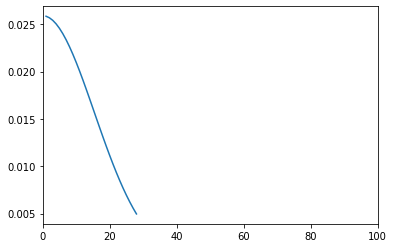

28 % completed. 6 seconds passed
Radius is 30 pixels now. Profile at this moment:


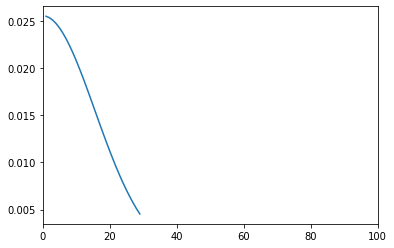

29 % completed. 6 seconds passed
Radius is 31 pixels now. Profile at this moment:


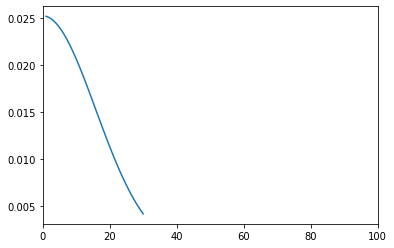

31 % completed. 6 seconds passed
Radius is 32 pixels now. Profile at this moment:


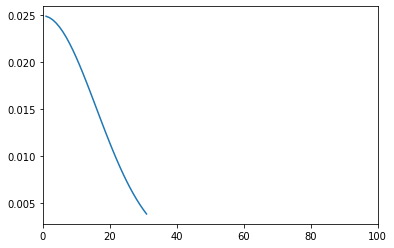

32 % completed. 7 seconds passed
Radius is 33 pixels now. Profile at this moment:


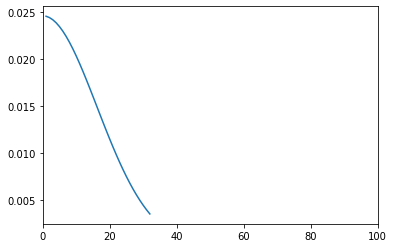

33 % completed. 7 seconds passed
Radius is 34 pixels now. Profile at this moment:


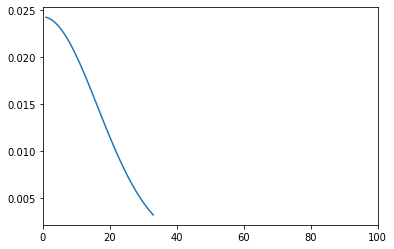

34 % completed. 7 seconds passed
Radius is 35 pixels now. Profile at this moment:


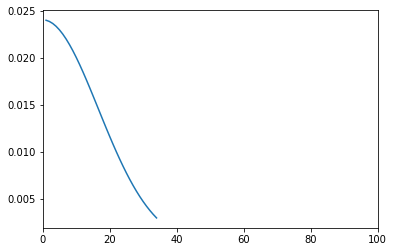

35 % completed. 8 seconds passed
Radius is 36 pixels now. Profile at this moment:


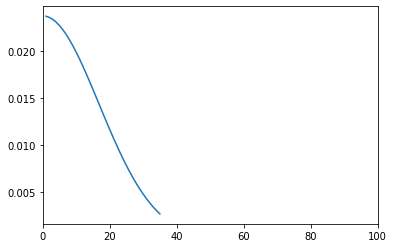

36 % completed. 8 seconds passed
Radius is 37 pixels now. Profile at this moment:


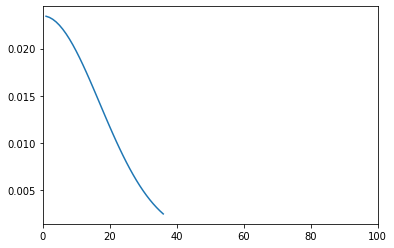

37 % completed. 8 seconds passed
Radius is 38 pixels now. Profile at this moment:


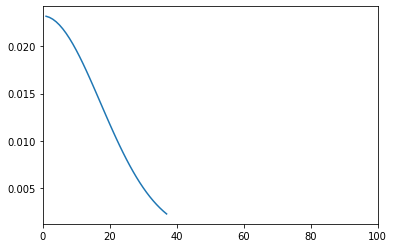

38 % completed. 9 seconds passed
Radius is 39 pixels now. Profile at this moment:


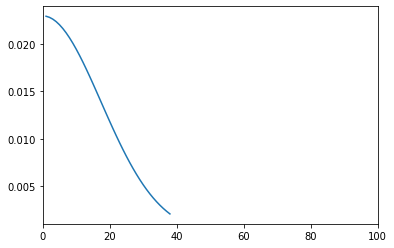

39 % completed. 9 seconds passed
Radius is 40 pixels now. Profile at this moment:


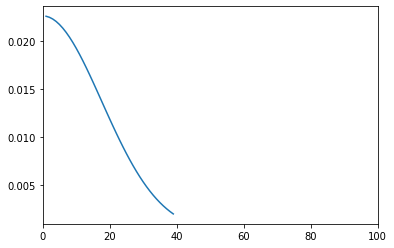

40 % completed. 9 seconds passed
Radius is 41 pixels now. Profile at this moment:


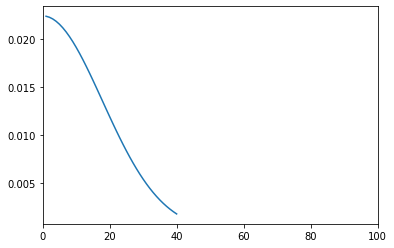

41 % completed. 9 seconds passed
Radius is 42 pixels now. Profile at this moment:


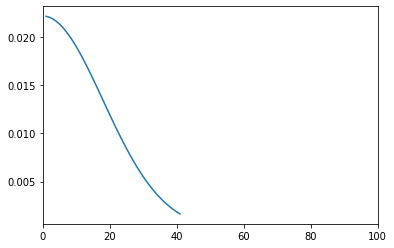

42 % completed. 10 seconds passed
Radius is 43 pixels now. Profile at this moment:


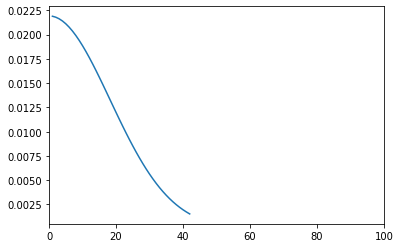

43 % completed. 10 seconds passed
Radius is 44 pixels now. Profile at this moment:


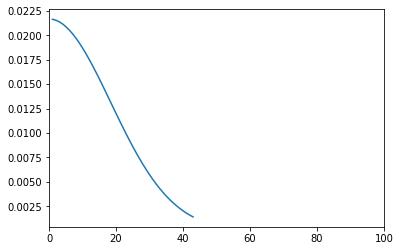

44 % completed. 10 seconds passed
Radius is 45 pixels now. Profile at this moment:


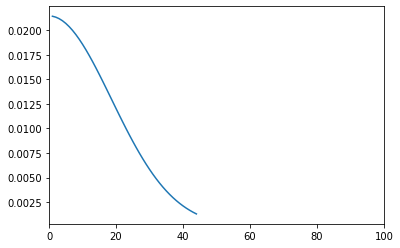

45 % completed. 11 seconds passed
Radius is 46 pixels now. Profile at this moment:


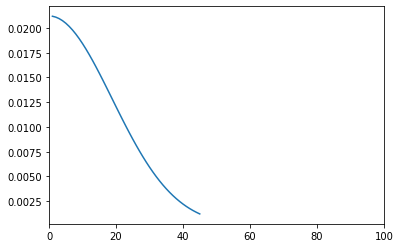

46 % completed. 11 seconds passed
Radius is 47 pixels now. Profile at this moment:


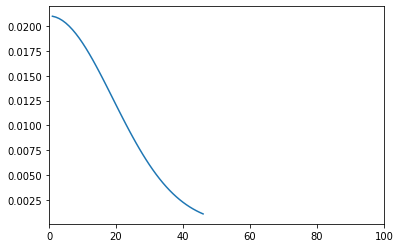

47 % completed. 12 seconds passed
Radius is 48 pixels now. Profile at this moment:


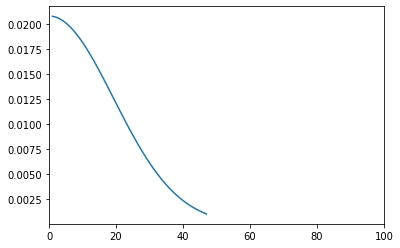

48 % completed. 12 seconds passed
Radius is 49 pixels now. Profile at this moment:


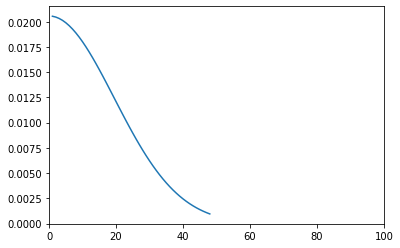

49 % completed. 12 seconds passed
Radius is 50 pixels now. Profile at this moment:


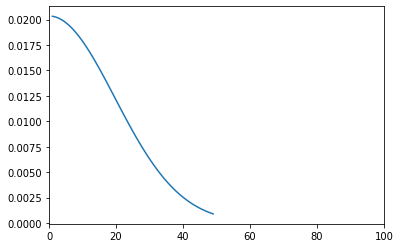

51 % completed. 13 seconds passed
Radius is 51 pixels now. Profile at this moment:


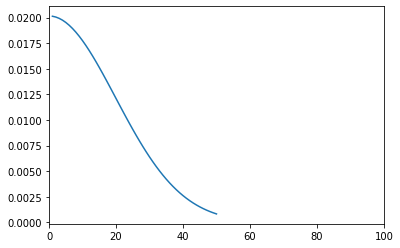

52 % completed. 13 seconds passed
Radius is 52 pixels now. Profile at this moment:


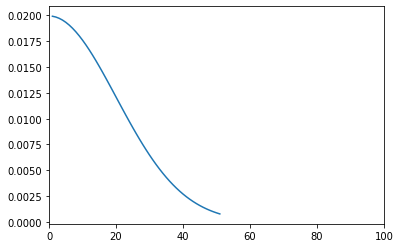

53 % completed. 14 seconds passed
Radius is 53 pixels now. Profile at this moment:


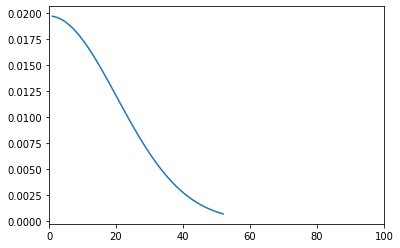

54 % completed. 14 seconds passed
Radius is 54 pixels now. Profile at this moment:


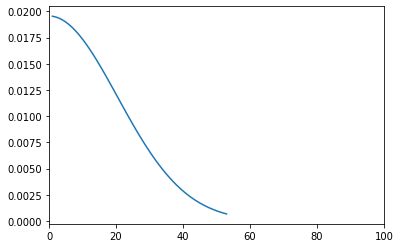

55 % completed. 15 seconds passed
Radius is 55 pixels now. Profile at this moment:


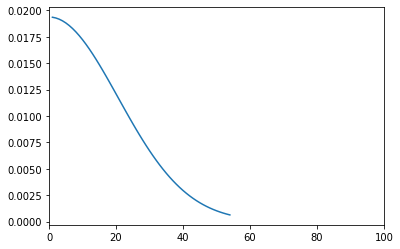

56 % completed. 15 seconds passed
Radius is 56 pixels now. Profile at this moment:


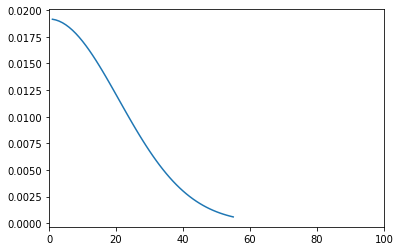

57 % completed. 15 seconds passed
Radius is 57 pixels now. Profile at this moment:


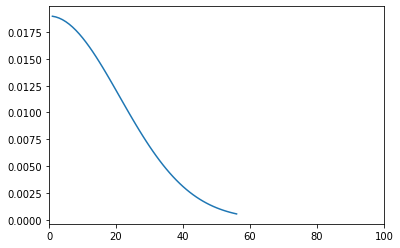

58 % completed. 16 seconds passed
Radius is 58 pixels now. Profile at this moment:


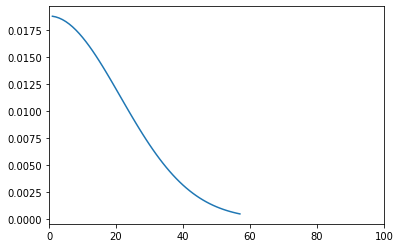

59 % completed. 16 seconds passed
Radius is 59 pixels now. Profile at this moment:


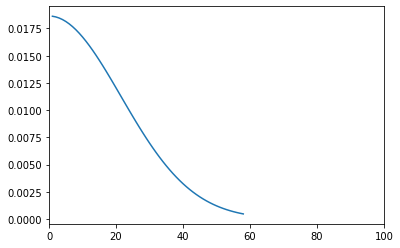

60 % completed. 17 seconds passed
Radius is 60 pixels now. Profile at this moment:


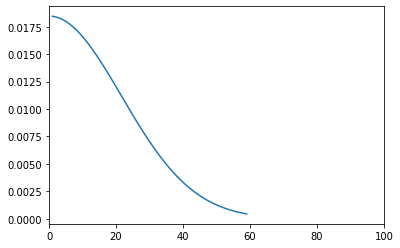

61 % completed. 17 seconds passed
Radius is 61 pixels now. Profile at this moment:


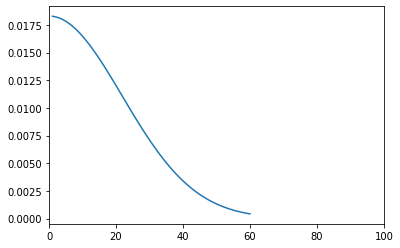

62 % completed. 18 seconds passed
Radius is 62 pixels now. Profile at this moment:


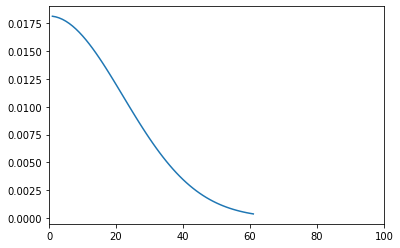

63 % completed. 18 seconds passed
Radius is 63 pixels now. Profile at this moment:


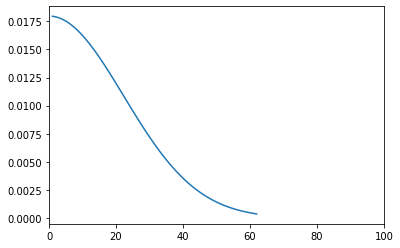

64 % completed. 19 seconds passed
Radius is 64 pixels now. Profile at this moment:


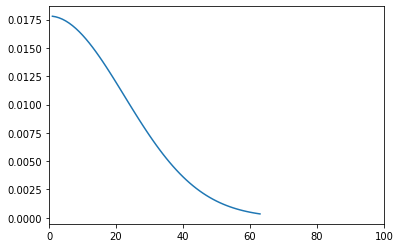

65 % completed. 19 seconds passed
Radius is 65 pixels now. Profile at this moment:


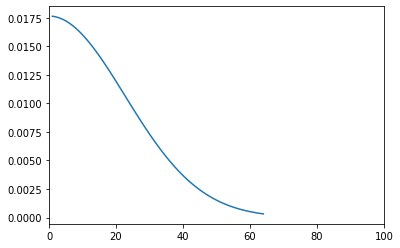

66 % completed. 20 seconds passed
Radius is 66 pixels now. Profile at this moment:


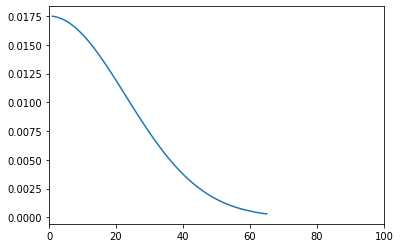

67 % completed. 20 seconds passed
Radius is 67 pixels now. Profile at this moment:


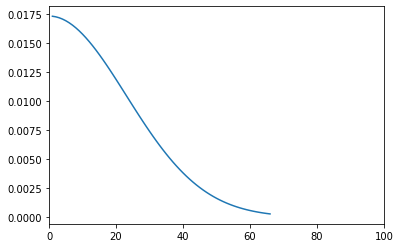

68 % completed. 21 seconds passed
Radius is 68 pixels now. Profile at this moment:


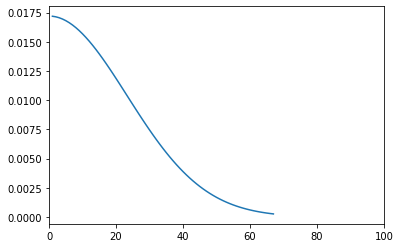

69 % completed. 21 seconds passed
Radius is 69 pixels now. Profile at this moment:


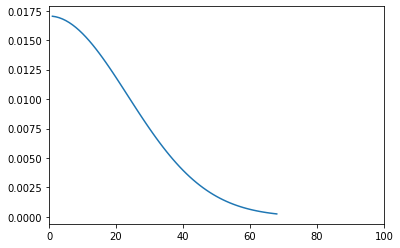

71 % completed. 22 seconds passed
Radius is 70 pixels now. Profile at this moment:


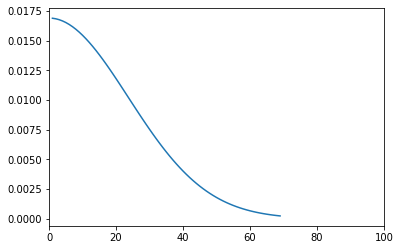

72 % completed. 23 seconds passed
Radius is 71 pixels now. Profile at this moment:


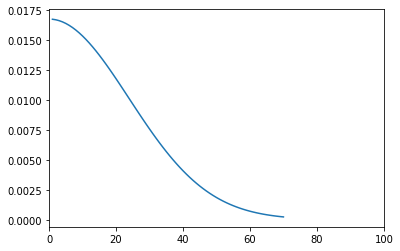

73 % completed. 23 seconds passed
Radius is 72 pixels now. Profile at this moment:


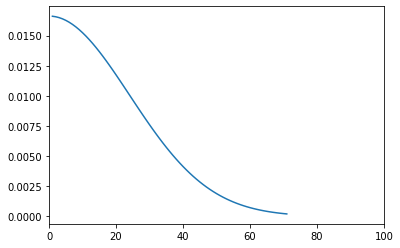

74 % completed. 24 seconds passed
Radius is 73 pixels now. Profile at this moment:


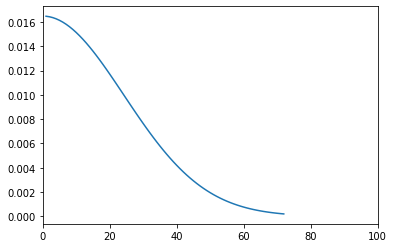

75 % completed. 24 seconds passed
Radius is 74 pixels now. Profile at this moment:


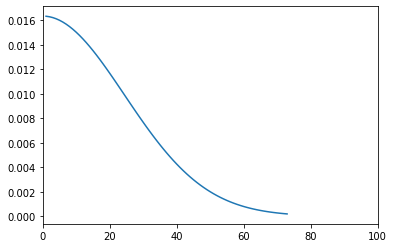

76 % completed. 25 seconds passed
Radius is 75 pixels now. Profile at this moment:


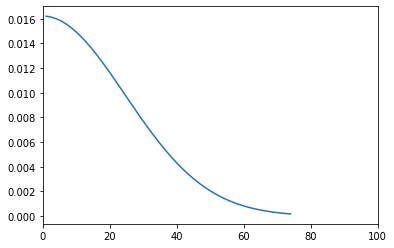

77 % completed. 26 seconds passed
Radius is 76 pixels now. Profile at this moment:


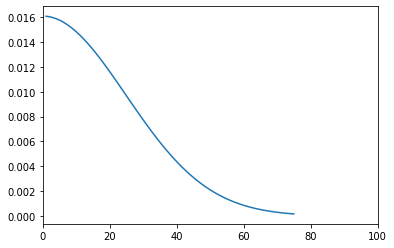

78 % completed. 26 seconds passed
Radius is 77 pixels now. Profile at this moment:


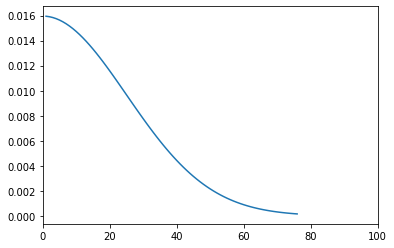

79 % completed. 27 seconds passed
Radius is 78 pixels now. Profile at this moment:


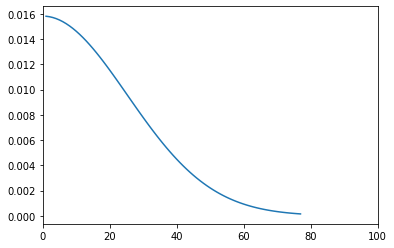

80 % completed. 28 seconds passed
Radius is 79 pixels now. Profile at this moment:


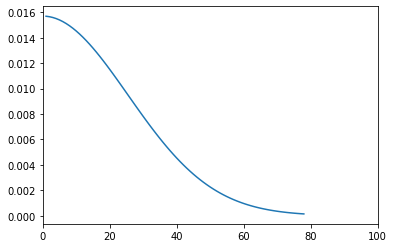

81 % completed. 28 seconds passed
Radius is 80 pixels now. Profile at this moment:


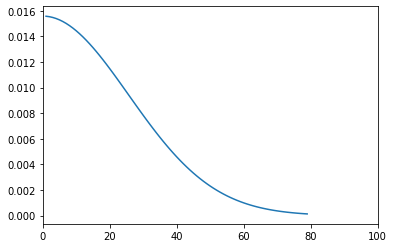

82 % completed. 29 seconds passed
Radius is 81 pixels now. Profile at this moment:


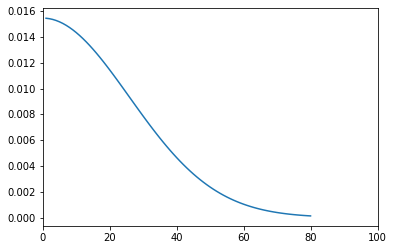

83 % completed. 30 seconds passed
Radius is 82 pixels now. Profile at this moment:


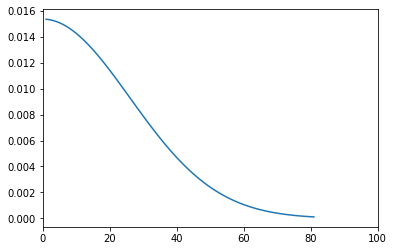

84 % completed. 31 seconds passed
Radius is 83 pixels now. Profile at this moment:


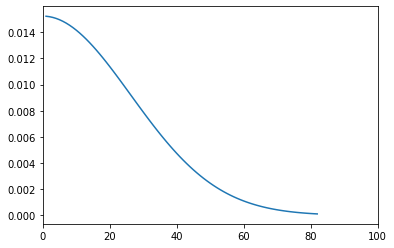

85 % completed. 31 seconds passed
Radius is 84 pixels now. Profile at this moment:


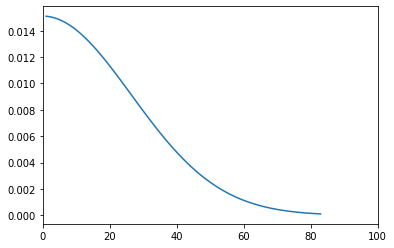

86 % completed. 32 seconds passed
Radius is 85 pixels now. Profile at this moment:


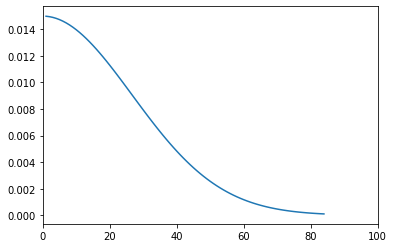

87 % completed. 33 seconds passed
Radius is 86 pixels now. Profile at this moment:


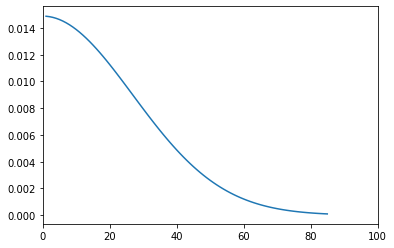

88 % completed. 34 seconds passed
Radius is 87 pixels now. Profile at this moment:


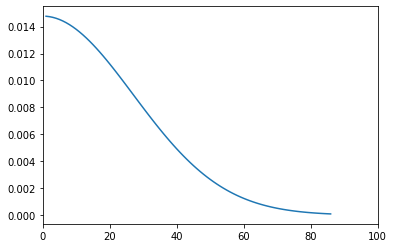

89 % completed. 35 seconds passed
Radius is 88 pixels now. Profile at this moment:


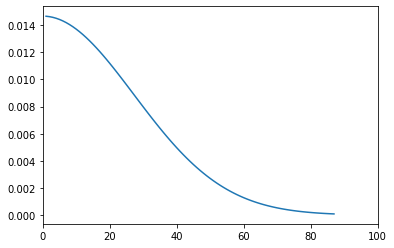

91 % completed. 35 seconds passed
Radius is 89 pixels now. Profile at this moment:


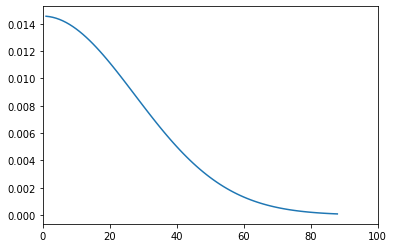

92 % completed. 36 seconds passed
Radius is 90 pixels now. Profile at this moment:


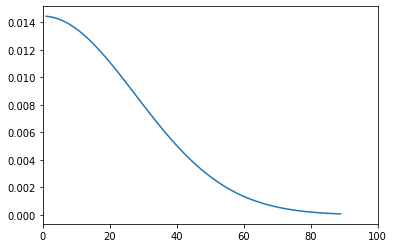

93 % completed. 37 seconds passed
Radius is 91 pixels now. Profile at this moment:


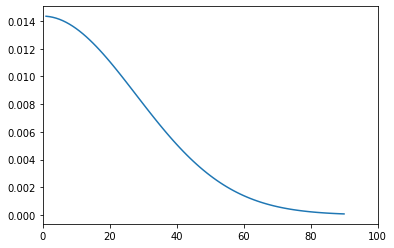

94 % completed. 38 seconds passed
Radius is 92 pixels now. Profile at this moment:


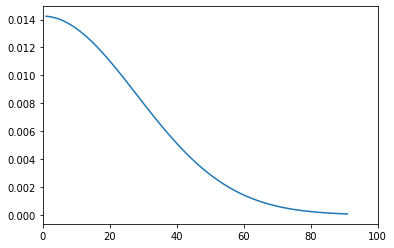

95 % completed. 39 seconds passed
Radius is 93 pixels now. Profile at this moment:


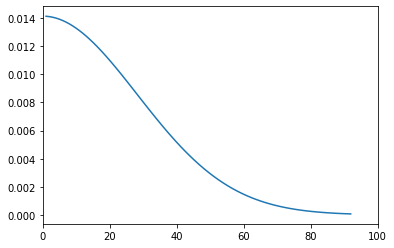

96 % completed. 40 seconds passed
Radius is 94 pixels now. Profile at this moment:


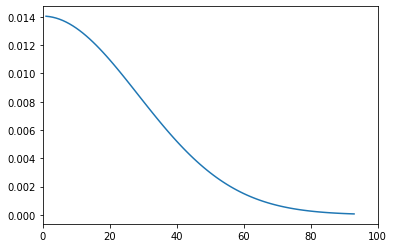

97 % completed. 41 seconds passed
Radius is 95 pixels now. Profile at this moment:


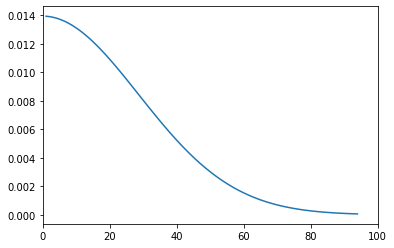

98 % completed. 42 seconds passed
Radius is 96 pixels now. Profile at this moment:


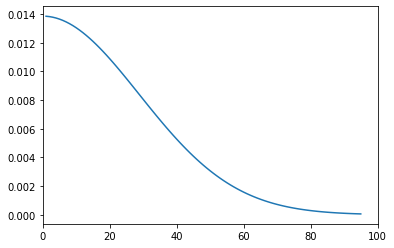

99 % completed. 43 seconds passed


In [ ]:
dm_gauss, dm_flat = micro(image, center, max_radius, time_grid, rads_grid, light_grid_gauss, light_grid_flat, Graphics=True)

In [ ]:
init = [*center, len(time_grid), *time_grid, *dm_gauss, *dm_flat]
init = [[*init], [*init]]
init

In [ ]:
from google.colab import files
import pandas as pd

pd.DataFrame(init).to_csv('delays6.csv', index=False)
#files.download('delays5.csv')

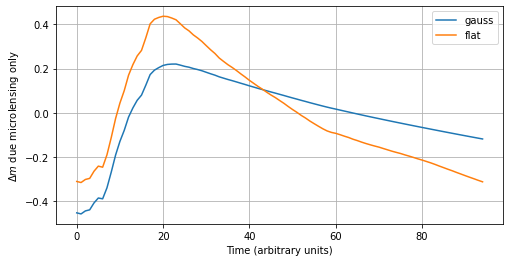

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(time_grid, dm_gauss - np.mean(dm_gauss), label='gauss')
plt.plot(time_grid, dm_flat - np.mean(dm_flat), label='flat')

#plt.axhline(np.mean(dm_gauss), color='r', linestyle='--', label='gauss mean')
#plt.axhline(np.mean(dm_flat), color='g', linestyle='--', label='flat mean')
#plt.gca().invert_yaxis()

plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.legend()
plt.grid()
plt.show()

# Сравниваем результаты с SNTD (для карт 1000х1000)

In [ ]:
! pip install sntd


     |████████████████████████████████| 14.6MB 287kB/s 
     |████████████████████████████████| 4.1MB 43.4MB/s 
     |████████████████████████████████| 204kB 46.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 337kB 45.6MB/s 
     |████████████████████████████████| 276kB 47.9MB/s 
     |████████████████████████████████| 163kB 47.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 235kB 49.2MB/s 
  Created wheel for sncosmo: filename=sncosmo-2.1.0-cp36-cp36m-linux_x86_64.whl size=502029 sha256=177d06dbf6e4a974486f92118504187b413d2f8c2ee2adda91a2b6ad62a148f0
  Stored in directory: /root/.cache/pip/wheels/e6/03/0d/f3894dfde500d44f2f6867322f8c04f7e2beabc4887322fa04
  Created wheel for extinction: filename=extinction-0.4.5-cp36-cp36m-linux_x86_64.whl

Сверим полученные результаты с работой SNTD.

Assuming velocity is in km/s.


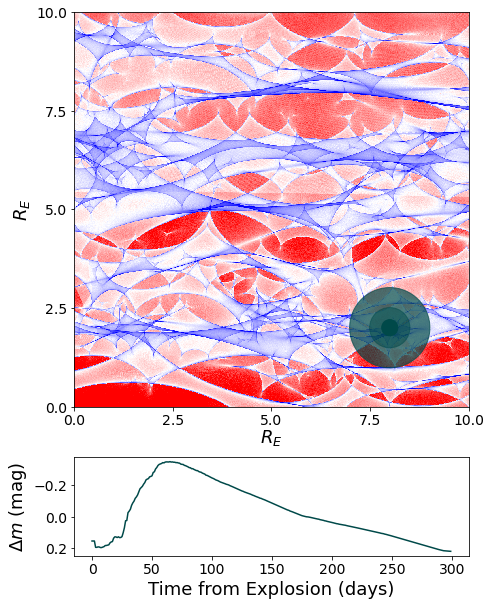

In [ ]:
import sntd

time1,dmag1 = sntd.microcaustic_field_to_curve(field = image_data,time=np.arange(0,300,1),zl=.5,zs=1.5, 
                                           velocity=20000,plot=True, loc=(800, 200) )

plt.show()

Для равномерно засвеченного источника получилось похоже. Сравним флуктуации поточечно.

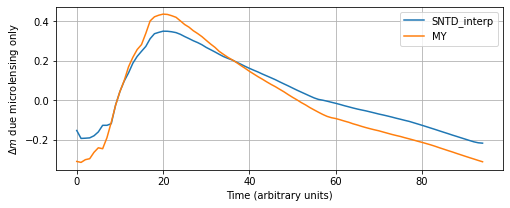

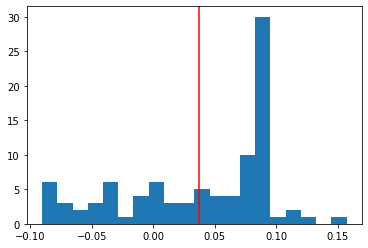

In [ ]:
plt.figure(figsize=(8,3))

factor = len(time1)/len(time_grid)

sntd_to_my = np.interp(time_grid*factor, time1, dmag1)

plt.plot(time_grid, 2.5*np.log10(sntd_to_my), label='SNTD_interp')
plt.plot(time_grid, dm_flat - np.mean(dm_flat), label='MY')

plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.grid()
plt.legend()
plt.show()

plt.hist(2.5*np.log10(sntd_to_my) - (dm_flat - np.mean(dm_flat)), bins = 20 )
plt.axvline(np.mean(2.5*np.log10(sntd_to_my) - (dm_flat - np.mean(dm_flat))), color = 'red' )
plt.show()